Imports

In [1]:
from drawing_bot_api.trajectory_optimizer.shape_generator import ShapeGenerator
from drawing_bot_api.trajectory_optimizer.shape_generator import RESTING_POINT
from drawing_bot_api import DrawingBot
from drawing_bot_api.trajectory_optimizer.image_processor import ImageProcessor
from drawing_bot_api.trajectory_optimizer.wiper import Wiper
from drawing_bot_api.trajectory_optimizer.simulator import PatternErrorSim
import cv2
import numpy as np
import matplotlib.pyplot as plt
from drawing_bot_api.trajectory_optimizer.training import Trainer
import signal
from drawing_bot_api.trajectory_optimizer.config import OUTPUT_SCALING
from scipy.ndimage import gaussian_filter1d


2024-12-17 17:18:09.453825: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
DEBUG_MODE = True

In [3]:
shape_generator = ShapeGenerator()
drawing_bot = DrawingBot()
image_processor = ImageProcessor()
wiper = Wiper()
error_simulator = PatternErrorSim(strength=15, pattern_length=20, seed=1)
model = Trainer()
reward_log = []

Unit set to "mm".


In [4]:
# handler for timeout
def handler(signum, frame):
    raise TimeoutError("Operation timed out")

signal.signal(signal.SIGALRM, handler)

<Handlers.SIG_DFL: 0>

In [5]:
def get_template():
    for shape in shape_generator():
        drawing_bot.add_shape(shape)
    # get template for drawing
    trajectory = np.array(drawing_bot._get_all_points())
    template = np.array(drawing_bot.plot(training_mode=True, points=trajectory))
    drawing_bot.shapes.clear()
    
    return trajectory, template

In [6]:

def get_adjusted_trajectory(trajectory, exploration_factor):
    offset = np.array(model.adjust_trajectory(trajectory, exploration_factor=exploration_factor))

    #print(offset)
    adjusted_trajectory = trajectory + offset
    adjusted_template = np.array(drawing_bot.plot(training_mode=True, points=adjusted_trajectory))
    return adjusted_trajectory, adjusted_template


In [7]:
def simulate_drawing(adjusted_trajectory):    
    simulated_trajctory = error_simulator(adjusted_trajectory)
    drawing = np.array(drawing_bot.plot(training_mode=True, points=simulated_trajctory))
    return simulated_trajctory, drawing


In [8]:
def calc_reward(similarity, type='default'):
    if type == 'default':
        return similarity
    
    elif type == 'avoid_zero':
        THRESHOLD = 0.5
        if similarity > THRESHOLD:
            return similarity
        else:
            return (((1-THRESHOLD)/THRESHOLD)*similarity - 1)

In [9]:
def fit_model(template, drawing):
    similarity = image_processor(template, drawing=drawing)
    reward = calc_reward(similarity)
    model.train(reward)
    return reward

In [10]:
def training_cycle(cycle_index, num_of_cycles):
    signal.alarm(5)

    try:
        trajectory, template = get_template()
        
    except TimeoutError as e:
        if DEBUG_MODE:
            raise
        else:
            print(f"Timeout occurred: {e}")

    finally:
        signal.alarm(0)  # Cancel the alarm

        try:
            exploration_factor = 0#.1 - (cycle_index/(10*num_of_cycles))
            print(f'Exploration factor: {exploration_factor}')
            #adjusted_trajectory, adjusted_template = get_adjusted_trajectory(trajectory, exploration_factor)
            simulated_trajctory, drawing = simulate_drawing(trajectory)#adjusted_trajectory)
            #reward_log.append(fit_model(template, drawing))
            print(f'Reward: {reward_log[-1]}')
        except Exception as e:
            if DEBUG_MODE:
                raise
            else:
                print('Something went wrong...')


Cylce: 0


Exploration factor: 0


IndexError: list index out of range

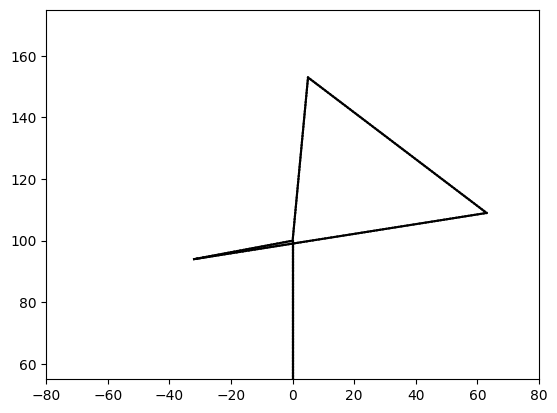

<Figure size 600x400 with 0 Axes>

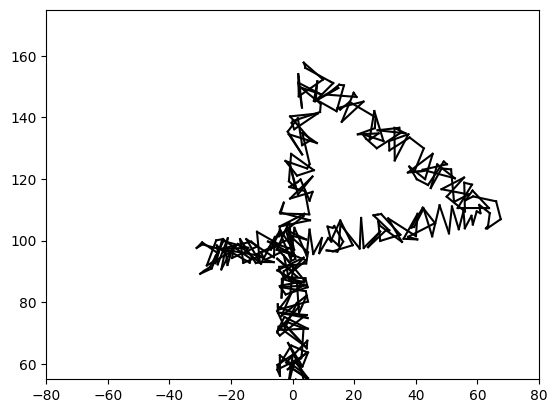

<Figure size 600x400 with 0 Axes>

In [11]:
NUM_OF_CYCLES = 20
inital_weights = []
for layer in model.model.layers:
    inital_weights.append(layer.get_weights()[0])

for i in range(NUM_OF_CYCLES):
    print(f'Cylce: {i}')
    training_cycle(i, NUM_OF_CYCLES)
    plt.close('all')

#plot rewards and losses
reward_log = gaussian_filter1d(reward_log, sigma=1)
loss_history = gaussian_filter1d(model.loss_history.losses, sigma=3)

end_weights = []
for layer in model.model.layers:
    end_weights.append(layer.get_weights()[0])

print(f'Initial weights:\n{inital_weights}')
print(f'\nWeights in the end:\n{end_weights}')

plt.plot(reward_log, label='Rewards')
plt.plot(loss_history, label='Losses')
plt.legend(bbox_to_anchor=(1, 1.15), ncol=3)    
plt.show()